In [1]:
import torch
from torchtext import data
import re
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
from torchvision.datasets import MNIST
from skimage import io, transform
import random

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from seglearn.transform import InterpLongToWide, SegmentX, FeatureRep, PadTrunc
from seglearn.pipe import Pype
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


# Evaluation of best model

In [4]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
#         self.fc1 = nn.Linear(hidden_dim, 100)
#         self.fc2 = nn.Linear(100, output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.dropout(out)
#         out = F.relu(self.fc1(out))
#         out = F.softmax(self.fc2(out[:, -1, :]), dim=1)
        out = self.fc2(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]



In [5]:
# DATALOADING
class ExerciseDataset(Dataset):
    """Shoulder exercise dataset"""
    
    def __init__(self, npy_file, length=None, transform=None, sanity_check=None):
        self.dataset = np.load(npy_file, allow_pickle=True).item()
        self.seq_length = length
        self.data = self.process_dataset(length)
        self.original_data = self.data.copy()
        self.data = self.data.astype(np.float)
        self.targets = self.dataset['exnum']
        self.original_targets = self.targets.copy()
#         self.subject = self.dataset['subject']
#         self.original_subject = self.subject.copy()
        
        self.transform = transform
        
        if sanity_check is not None:
            self.data = [self.data[sanity_check]]
            self.targets = [self.targets[sanity_check]]

        assert (len(self.data) == len(self.targets))
        
    def process_dataset(self, length):
        shape = [data.shape[0] for data in self.dataset['X']]
        if length is None:
            average_len = round(sum(shape) / len(shape))
            self.seq_length = average_len
        processed, _, _ = PadTrunc(width=self.seq_length).transform(X=self.dataset['X'])
        return processed
    
    def fold(self, fold_indices):
        # Create fold for K-fold validation
        self.data = self.original_data[fold_indices]
        self.targets = self.original_targets[fold_indices]
        self.subject = self.original_subject[fold_indices]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return torch.from_numpy(self.data[idx][:, 1:]), self.targets[idx]

In [6]:
exercises = {
    0: 'PEN',
    1: 'FLEX',
    2: 'SCAP',
    3: 'ABD',
    4: 'IR',
    5: 'ER',
    6: 'DIAG',
    7: 'ROW',
    8: 'SLR'
}

In [7]:
#Model
input_dim = 3
hidden_dim = 128
layer_dim = 3
output_dim = 9 # 9 classes
# seq_dim = dataset.seq_length

# iterations_per_epoch = len(train_loader)
best_acc = 0
patience, trials = 100, 0

In [8]:
# dataset = ExerciseDataset("resampled_nar.npy")
# dataset = ExerciseDataset("recon_synthetic_acc_nar.npy")
# dataset = ExerciseDataset("recon_vrae.npy")
# dataset = ExerciseDataset("recon_acc.npy", length=200)
# recon_dataset = ExerciseDataset("recons.npy", length=200)
# new_dataset = ExerciseDataset("generated.npy", length=200)
dataset = ExerciseDataset("cropped_resampled_acc_nar.npy", length=200)

In [26]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
assert train_size + test_size == len(dataset)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [27]:
len(test_dataset)

6522

In [28]:
# test_loader = DataLoader(dataset, batch_size=4, num_workers=6, shuffle=False, drop_last=True)

In [29]:
# dataset = new_dataset
# index = np.random.randint(50)
# plt.rcParams.update({'font.size': 22})
# plt.figure(figsize=(24, 12))
# label = dataset[index][1][0]
# print("Label: {}".format(dataset[index][1]))
# plt.plot(dataset[index][0][:, 0], label="x")
# plt.plot(dataset[index][0][:, 1], label="y")
# plt.plot(dataset[index][0][:, 2], label="z")


# plt.plot(dataset.dataset['original'][index][:, 0], label="recon_x")
# plt.plot(dataset.dataset['original'][index][:, 1], label="recon_y")
# plt.plot(dataset.dataset['original'][index][:, 2], label="recon_z")
# plt.legend(loc="upper left")
# plt.title("Sequence reconstruction example (exercise: {})".format(exercises[label]))
# plt.xlabel("Time [s]")
# plt.ylabel(r'acceleration $[ms^{-2}]$')

In [30]:
# original = dataset.dataset['original']
# original.shape

In [31]:
torch.multiprocessing.set_sharing_strategy('file_system')
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False, drop_last=True)

In [46]:
clf = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, 0.5)
# clf.load_state_dict(torch.load("best_200_92.pth"))
# clf.load_state_dict(torch.load("clf_pre_aug.pth"))
clf.load_state_dict(torch.load("clf_post_aug.pth"))
clf = clf.cuda()
clf.eval()

LSTMClassifier(
  (rnn): LSTM(3, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [47]:
# Evaluation
predicted = []
actual = []
total = 0
correct = 0
for j, val in enumerate(test_loader):
    x_val, y_val = val
    actual.append(y_val.numpy())
    
    x_val = x_val.float().cuda()
    y_val = y_val.float().cuda()

    out = clf(x_val)
    preds = F.softmax(out, dim=1).argmax(dim=1)
    predicted.append(preds.cpu().numpy())
    
    total += y_val.size(0)
    correct += (preds == y_val).sum().item()
acc = correct / total
print("Overall accuracY: {}".format(acc))

Overall accuracY: 0.7795154860472248


In [48]:
round(acc * 100, 2)

77.95

In [49]:
ac = [label for array in actual for label in array]

In [50]:
pre = [label for array in predicted for label in array]

In [51]:
labels = ['PEN','FLEX', 'SCAP', 'ABD', 'IR', 'ER', 'DIAG', 'ROW', 'SLR']

Text(0.5, 1.05, 'Post-augmentation accuracy: 77.95')

<Figure size 1728x1728 with 0 Axes>

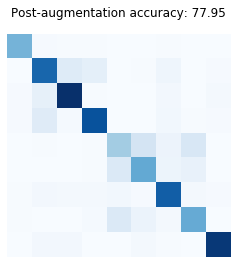

In [52]:
# Confusion matrix
plt.figure(figsize=(24, 24))
conf_matrix = confusion_matrix(ac, pre)
plt.matshow(conf_matrix, cmap='Blues', interpolation='nearest')
# plt.colorbar()
plt.axis('off')
plt.title("Post-augmentation accuracy: {}".format(round(acc*100, 2)))
# print(classification_report(ac, pre))

In [22]:
from sklearn.metrics import pl

ImportError: cannot import name 'pl' from 'sklearn.metrics' (/home/lja/Documents/waterloo/4A/CS/assignments/lib/python3.7/site-packages/sklearn/metrics/__init__.py)